Network Intrusion Detection

In [4]:
print("Muhammad Irgiansyah (103012300039)")
print("Bill Stephen Sembiring (103012330197)")

Muhammad Irgiansyah (103012300039)
Bill Stephen Sembiring (103012330197)


KNN

Nilai k optimal: 1 (Akurasi: 0.9950)

=== Evaluasi Akurasi untuk Setiap Nilai k ===
k = 1: Akurasi = 0.9950
k = 2: Akurasi = 0.9900
k = 3: Akurasi = 0.9900
k = 4: Akurasi = 0.9850
k = 5: Akurasi = 0.9850
k = 6: Akurasi = 0.9800
k = 7: Akurasi = 0.9800
k = 8: Akurasi = 0.9800
k = 9: Akurasi = 0.9800
k = 10: Akurasi = 0.9700

[Training]     Akurasi: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1-score: 1.0000


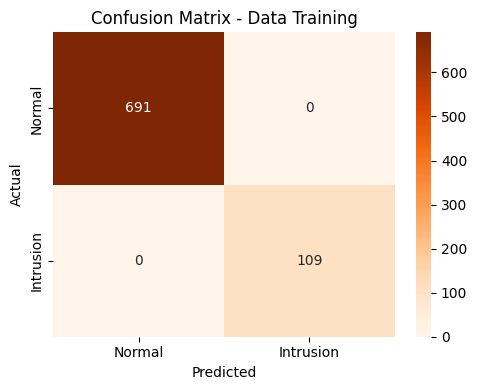

[Testing]      Akurasi: 0.9950 | Precision: 1.0000 | Recall: 0.9697 | F1-score: 0.9846


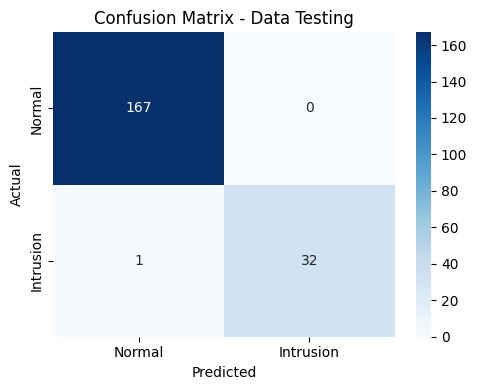

[Keseluruhan]  Akurasi: 0.9990 | Precision: 1.0000 | Recall: 0.9930 | F1-score: 0.9965


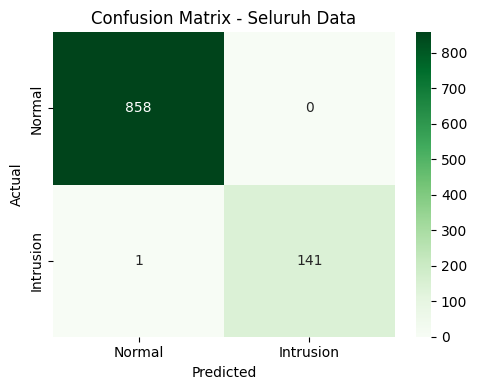


=== Evaluasi Klasifikasi Multi-Kelas - Training ===
Akurasi: 1.0000
Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       777
       Probe       1.00      1.00      1.00        23

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



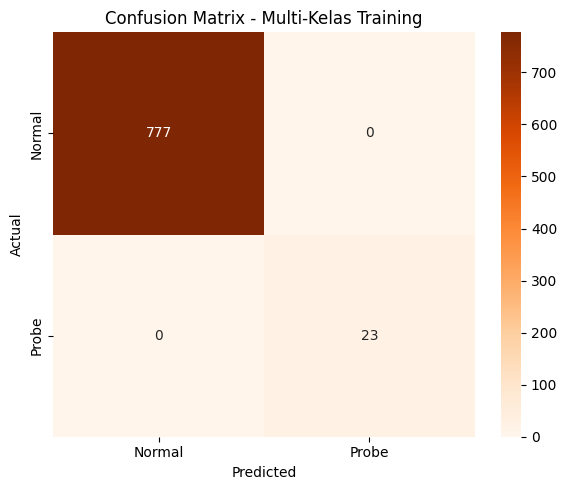


=== Evaluasi Klasifikasi Multi-Kelas - Testing ===
Akurasi: 1.0000
Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       192
       Probe       1.00      1.00      1.00         8

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



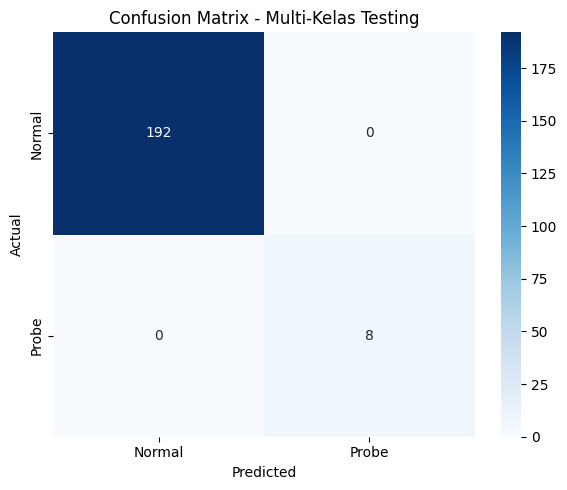


=== Evaluasi Klasifikasi Multi-Kelas - Keseluruhan ===
Akurasi: 1.0000
Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       969
       Probe       1.00      1.00      1.00        31

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



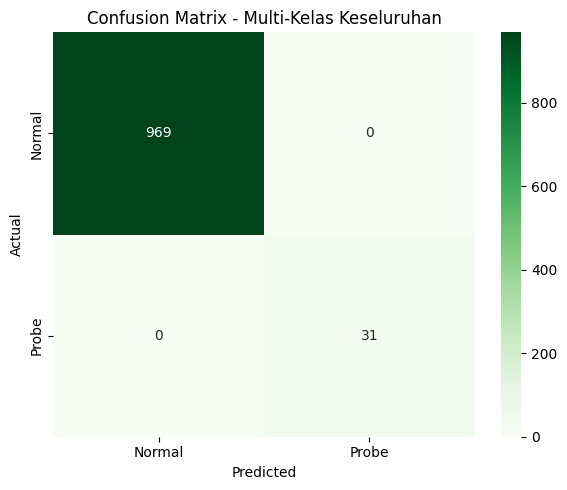


=== Contoh Hasil Prediksi Multi-Kelas ===
     Actual Predicted
521  Normal    Normal
737  Normal    Normal
740  Normal    Normal
660  Normal    Normal
411  Normal    Normal
678  Normal    Normal
626  Normal    Normal
513  Normal    Normal
859  Normal    Normal
136  Normal    Normal


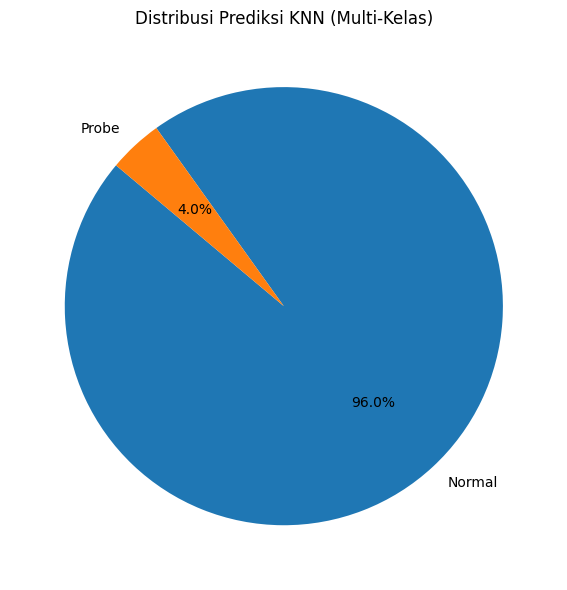


=== Evaluasi Akurasi Berbagai Split Data ===
Split 90:10 - Akurasi: 0.9900
Split 80:20 - Akurasi: 0.9900
Split 70:30 - Akurasi: 0.9900
Split 60:40 - Akurasi: 0.9925
Split 50:50 - Akurasi: 0.9760

Data dimodifikasi secara acak pada 50 baris (augmentasi dengan noise ringan)

Wilcoxon test untuk src_bytes: statistic = 624.0000, p-value = 0.9010


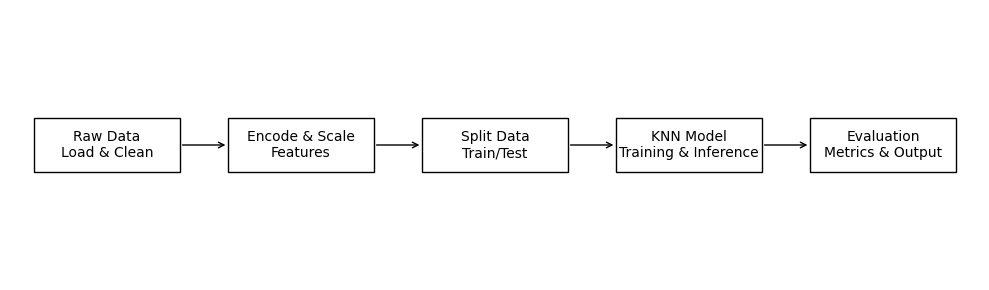

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# === 1. Load dan Bersihkan Data ===
df = pd.read_csv('D:\MATERI KULIAH\Semester 4\Dasar Kecerdasan Artifisial\Tubes\Test_data.csv\Test_data.csv')
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# === 2. Pilih Fitur Penting ===
selected_features = ['duration', 'protocol_type', 'service', 'flag',
                     'src_bytes', 'dst_bytes', 'count', 'srv_count']
df = df[selected_features].copy()

# === 3. Label Biner (Normal vs Intrusion) ===
df['binary_label'] = df['src_bytes'].astype(int).apply(lambda x: 0 if x <= 500 else 1)

# === 4. Encode Fitur Kategorikal ===
cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# === 5. Normalisasi untuk scoring klasifikasi multi-kelas ===
scaler_temp = MinMaxScaler()
df[['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']] = scaler_temp.fit_transform(
    df[['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']]
)

# === 6. Tambah Label Multi-Kelas Berdasarkan Skor dan dst_bytes ===
def compute_score(row):
    score = (
        row['duration'] * 0.2 +
        row['src_bytes'] * 0.2 +
        row['dst_bytes'] * 0.2 +
        row['count'] * 0.2 +
        row['srv_count'] * 0.2
    ) * 100
    return score

def classify(score, dst_bytes):
    if score <= 30:
        return 'Normal'
    elif score <= 60:
        return 'Probe'
    elif score <= 80:
        return 'R2L'
    else:
        return 'DoS' if dst_bytes > 0.5 else 'U2R'

def run_knn_cv(X, y, n_splits=5):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_probas = []
    start_time = time.time()

    for train_i, test_i in skf.split(X, y):
        Xtr, Xte = X.iloc[train_i], X.iloc[test_i]
        ytr, yte = y.iloc[train_i], y.iloc[test_i]

        best_k, best_acc = 1, 0
        for k in range(1, 11):
            model = KNeighborsClassifier(n_neighbors=k).fit(Xtr, ytr)
            acc = accuracy_score(yte, model.predict(Xte))
            if acc > best_acc:
                best_k, best_acc = k, acc

        knn_best = KNeighborsClassifier(n_neighbors=best_k).fit(Xtr, ytr)
        probas = knn_best.predict_proba(Xte)[:, 1]
        all_probas.extend(probas)

    end_time = time.time()
    elapsed = end_time - start_time
    return np.array(all_probas), elapsed


df['score'] = df.apply(compute_score, axis=1)
df['attack_type'] = df.apply(lambda row: classify(row['score'], row['dst_bytes']), axis=1)

# === Upper Scaling: Batasi 1000 data pertama ===
df = df.head(1000).copy()

# === 7. Pisahkan Fitur dan Label ===
X = df.drop(['binary_label', 'attack_type', 'score'], axis=1)
y_bin = df['binary_label']
y_multi = df['attack_type']

# === 8. Split Data 80:20 ===
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_bin, test_size=0.2, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# === 9. Normalisasi Fitur Numerik ===
numeric_cols = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
scaler = MinMaxScaler()
X_train_bin[numeric_cols] = scaler.fit_transform(X_train_bin[numeric_cols])
X_test_bin[numeric_cols] = scaler.transform(X_test_bin[numeric_cols])
X_train_multi[numeric_cols] = scaler.fit_transform(X_train_multi[numeric_cols])
X_test_multi[numeric_cols] = scaler.transform(X_test_multi[numeric_cols])

# === 10. Evaluasi Nilai k Terbaik ===
k_values = list(range(1, 11))
acc_scores = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_bin, y_train_bin)
    pred = model.predict(X_test_bin)
    acc_scores.append(accuracy_score(y_test_bin, pred))
optimal_k = k_values[np.argmax(acc_scores)]
print(f"Nilai k optimal: {optimal_k} (Akurasi: {acc_scores[np.argmax(acc_scores)]:.4f})")

print("\n=== Evaluasi Akurasi untuk Setiap Nilai k ===")
for i, k in enumerate(k_values):
    print(f"k = {k}: Akurasi = {acc_scores[i]:.4f}")

# === 11. Klasifikasi Biner dengan K Optimal ===
knn_bin = KNeighborsClassifier(n_neighbors=optimal_k)
knn_bin.fit(X_train_bin, y_train_bin)

# === Evaluasi pada Data Training ===
y_train_pred_bin = knn_bin.predict(X_train_bin)
train_acc_bin = accuracy_score(y_train_bin, y_train_pred_bin)
train_prec_bin = precision_score(y_train_bin, y_train_pred_bin, zero_division=0)
train_rec_bin = recall_score(y_train_bin, y_train_pred_bin, zero_division=0)
train_f1_bin = f1_score(y_train_bin, y_train_pred_bin, zero_division=0)
print(f"\n[Training]     Akurasi: {train_acc_bin:.4f} | Precision: {train_prec_bin:.4f} | Recall: {train_rec_bin:.4f} | F1-score: {train_f1_bin:.4f}")
# Confusion Matrix - Data Training
cm_train = confusion_matrix(y_train_bin, y_train_pred_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.title("Confusion Matrix - Data Training")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Evaluasi pada Data Uji (Testing) ===
y_test_pred_bin = knn_bin.predict(X_test_bin)
test_acc_bin = accuracy_score(y_test_bin, y_test_pred_bin)
test_prec_bin = precision_score(y_test_bin, y_test_pred_bin, zero_division=0)
test_rec_bin = recall_score(y_test_bin, y_test_pred_bin, zero_division=0)
test_f1_bin = f1_score(y_test_bin, y_test_pred_bin, zero_division=0)
print(f"[Testing]      Akurasi: {test_acc_bin:.4f} | Precision: {test_prec_bin:.4f} | Recall: {test_rec_bin:.4f} | F1-score: {test_f1_bin:.4f}")
# Confusion Matrix - Data Testing
cm_test = confusion_matrix(y_test_bin, y_test_pred_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.title("Confusion Matrix - Data Testing")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === Evaluasi pada Seluruh Data Gabungan ===
X_all_bin = pd.concat([X_train_bin, X_test_bin])
y_all_bin = pd.concat([y_train_bin, y_test_bin])
y_all_pred_bin = knn_bin.predict(X_all_bin)
all_acc_bin = accuracy_score(y_all_bin, y_all_pred_bin)
all_prec_bin = precision_score(y_all_bin, y_all_pred_bin, zero_division=0)
all_rec_bin = recall_score(y_all_bin, y_all_pred_bin, zero_division=0)
all_f1_bin = f1_score(y_all_bin, y_all_pred_bin, zero_division=0)
print(f"[Keseluruhan]  Akurasi: {all_acc_bin:.4f} | Precision: {all_prec_bin:.4f} | Recall: {all_rec_bin:.4f} | F1-score: {all_f1_bin:.4f}")
# Confusion Matrix - Seluruh Data
cm_all = confusion_matrix(y_all_bin, y_all_pred_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.title("Confusion Matrix - Seluruh Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === 12. Klasifikasi Multi-Kelas ===
knn_multi = KNeighborsClassifier(n_neighbors=optimal_k)
knn_multi.fit(X_train_multi, y_train_multi)

# Tentukan semua label unik yang mungkin muncul dalam dataset
labels_multi = sorted(df['attack_type'].unique())

# === Evaluasi pada Data Training (Multi-Kelas) ===
y_train_pred_multi = knn_multi.predict(X_train_multi)
train_acc_multi = accuracy_score(y_train_multi, y_train_pred_multi)
print("\n=== Evaluasi Klasifikasi Multi-Kelas - Training ===")
print(f"Akurasi: {train_acc_multi:.4f}")
print("Classification Report:\n", classification_report(y_train_multi, y_train_pred_multi, labels=labels_multi))
cm_train_multi = confusion_matrix(y_train_multi, y_train_pred_multi, labels=labels_multi)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train_multi, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels_multi,
            yticklabels=labels_multi)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multi-Kelas Training')
plt.tight_layout()
plt.show()

# === Evaluasi pada Data Testing (Multi-Kelas) ===
y_test_pred_multi = knn_multi.predict(X_test_multi)
test_acc_multi = accuracy_score(y_test_multi, y_test_pred_multi)
print("\n=== Evaluasi Klasifikasi Multi-Kelas - Testing ===")
print(f"Akurasi: {test_acc_multi:.4f}")
print("Classification Report:\n", classification_report(y_test_multi, y_test_pred_multi, labels=labels_multi))
cm_test_multi = confusion_matrix(y_test_multi, y_test_pred_multi, labels=labels_multi)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_multi,
            yticklabels=labels_multi)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multi-Kelas Testing')
plt.tight_layout()
plt.show()

# === Evaluasi pada Seluruh Data Gabungan (Multi-Kelas) ===
X_all_multi = pd.concat([X_train_multi, X_test_multi])
y_all_multi = pd.concat([y_train_multi, y_test_multi])
y_all_pred_multi = knn_multi.predict(X_all_multi)
all_acc_multi = accuracy_score(y_all_multi, y_all_pred_multi)
print("\n=== Evaluasi Klasifikasi Multi-Kelas - Keseluruhan ===")
print(f"Akurasi: {all_acc_multi:.4f}")
print("Classification Report:\n", classification_report(y_all_multi, y_all_pred_multi, labels=labels_multi))
cm_all_multi = confusion_matrix(y_all_multi, y_all_pred_multi, labels=labels_multi)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_all_multi, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_multi,
            yticklabels=labels_multi)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multi-Kelas Keseluruhan')
plt.tight_layout()
plt.show()

# === Contoh Hasil Prediksi Multi-Kelas ===
y_pred_multi = knn_multi.predict(X_test_multi)

results_df = pd.DataFrame({
    'Actual': y_test_multi,
    'Predicted': y_pred_multi
})
print("\n=== Contoh Hasil Prediksi Multi-Kelas ===")
print(results_df.head(10))

pd.Series(y_pred_multi).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(6, 6))
plt.title("Distribusi Prediksi KNN (Multi-Kelas)")
plt.ylabel('')
plt.tight_layout()
plt.show()

# === Evaluasi Beberapa Split Data ===
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
print("\n=== Evaluasi Akurasi Berbagai Split Data ===")
for ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=ratio, random_state=42)
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Split {int((1-ratio)*100)}:{int(ratio*100)} - Akurasi: {acc:.4f}")

# === Augmentasi Data dan Wilcoxon Test (dengan noise ringan) ===
df_aug = df.copy()
indices_to_modify = np.random.choice(df_aug.index, size=int(0.05 * len(df_aug)), replace=False)
df_aug.loc[indices_to_modify, 'src_bytes'] += np.random.normal(loc=0, scale=10, size=len(indices_to_modify))

print(f"\nData dimodifikasi secara acak pada {len(indices_to_modify)} baris (augmentasi dengan noise ringan)")

original = df['src_bytes'].loc[indices_to_modify].copy()
augmented = df_aug['src_bytes'].loc[indices_to_modify].copy()

if len(original) == len(augmented):
    stat, p = wilcoxon(original, augmented)
    print(f"\nWilcoxon test untuk src_bytes: statistic = {stat:.4f}, p-value = {p:.4f}")
else:
    print("\nTidak cukup data sepadan untuk Wilcoxon test.")

# === Blok Diagram KNN ===
# Create block diagram for KNN classification pipeline
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_axis_off()

# Define block positions and labels
blocks = [
    ("Raw Data\nLoad & Clean", 0.1),
    ("Encode & Scale\nFeatures", 0.3),
    ("Split Data\nTrain/Test", 0.5),
    ("KNN Model\nTraining & Inference", 0.7),
    ("Evaluation\nMetrics & Output", 0.9),
]

# Draw blocks and arrows
width, height = 0.15, 0.2
for label, x in blocks:
    rect = Rectangle((x - width/2, 0.4), width, height, fill=False)
    ax.add_patch(rect)
    ax.text(x, 0.5, label, ha='center', va='center')
# Draw arrows between blocks
for i in range(len(blocks) - 1):
    x_start = blocks[i][1] + width/2
    x_end = blocks[i+1][1] - width/2
    ax.annotate("",
                xy=(x_end, 0.5), xytext=(x_start, 0.5),
                arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

FUZZY MAMDANI

C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


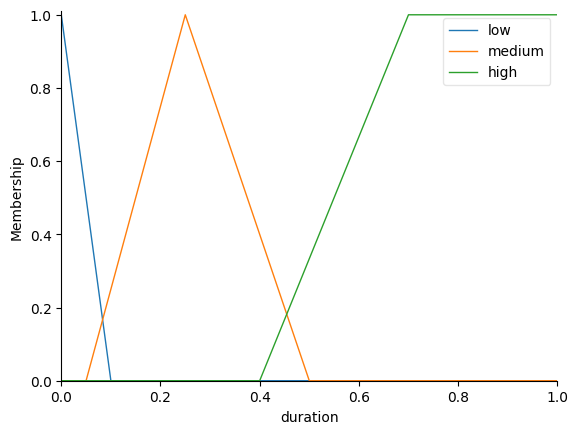

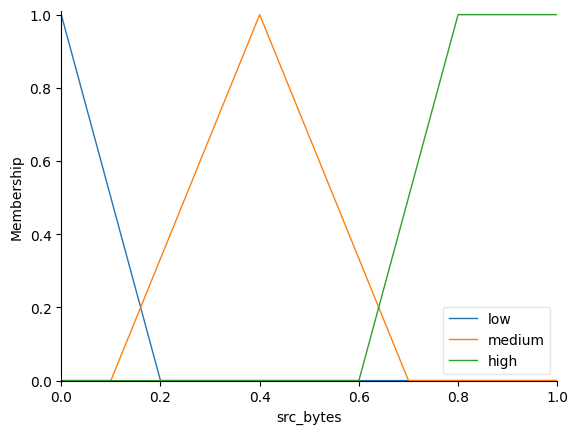

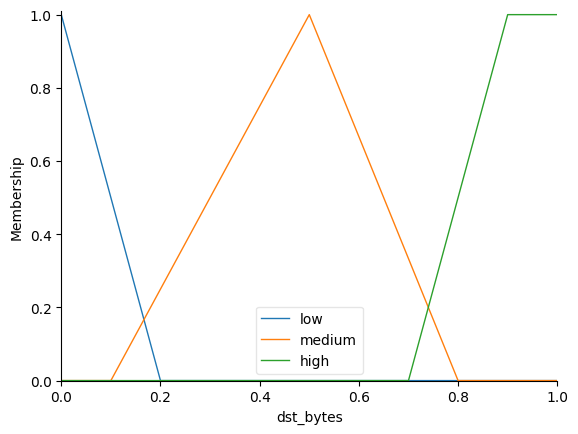

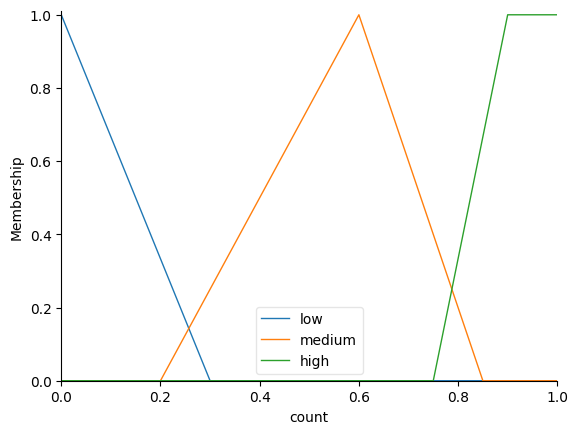

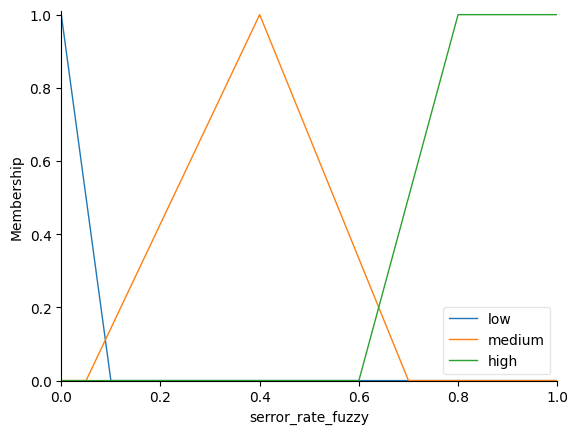

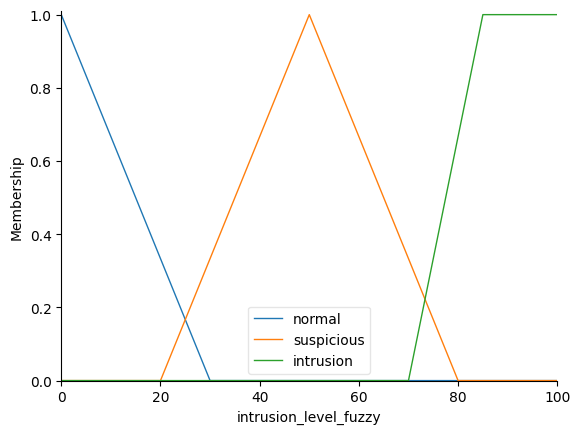

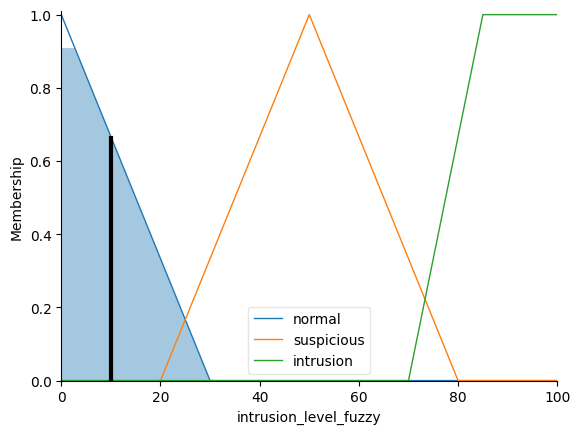

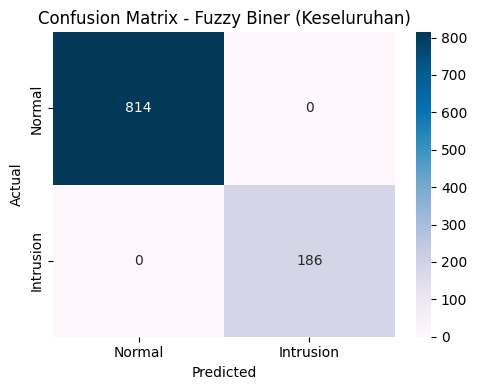

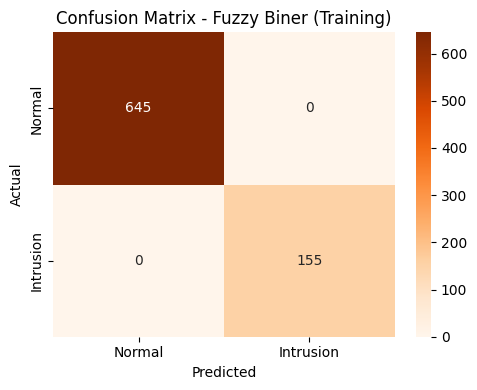

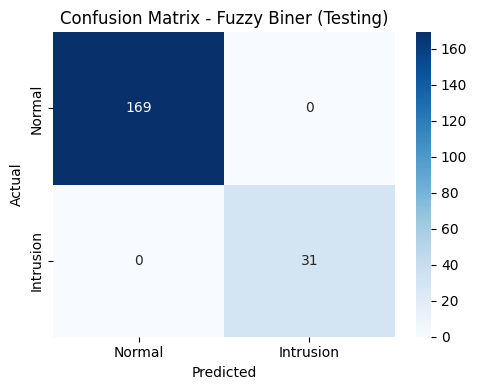

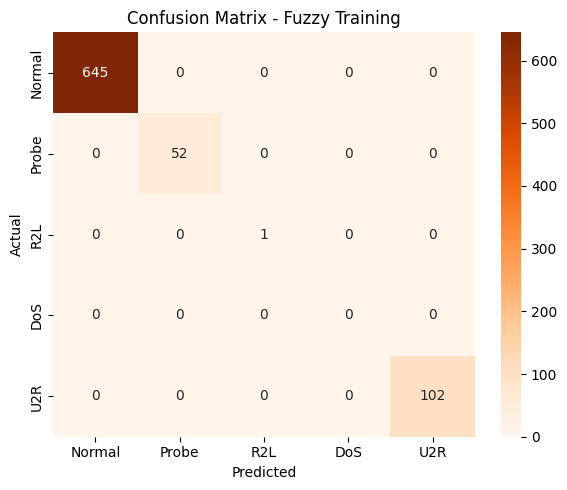

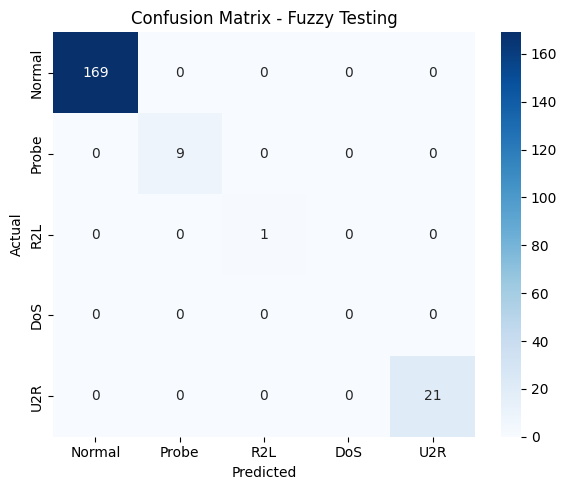

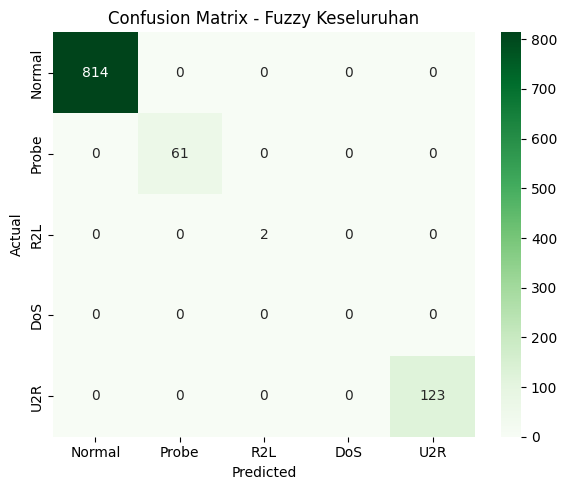

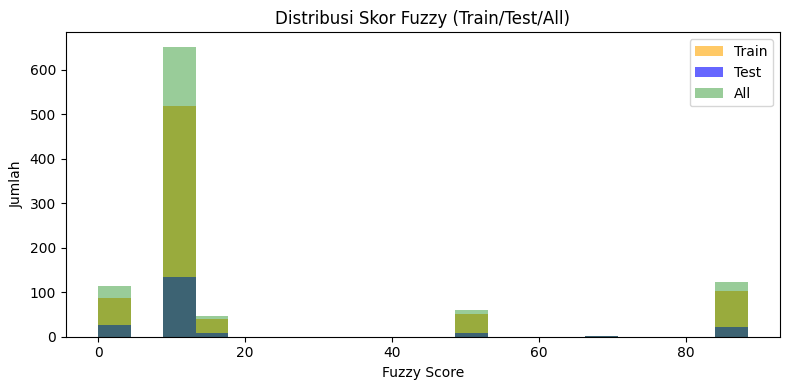

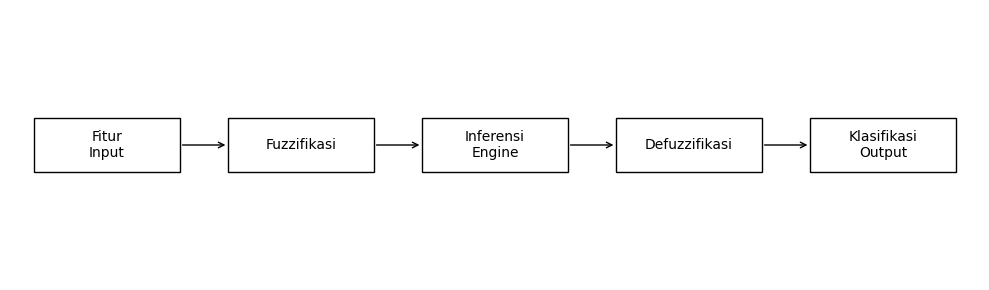


=== Evaluasi Fuzzy (Biner) ===
Akurasi  : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-Score : 1.0000

=== Evaluasi Fuzzy (Multi-Kelas) ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       814
       Probe       1.00      1.00      1.00        61
         R2L       1.00      1.00      1.00         2
         U2R       1.00      1.00      1.00       123

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


=== Contoh Fuzzy Scores ===
[10.001680143517854, 88.33333333333333, 10.00100681865175, 10.003756136588146, 10.000607006789583, 88.33333333333333, 13.526815475907377, 10.260031664735994, 10.136672069188625, 10.010301890726605]

Data dimodifikasi secara acak pada 50 baris (augmentasi dengan noise ringan)

Wilcoxon test untuk src_bytes: statistic = 479.0000, p-value = 0.1280


In [2]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from matplotlib.patches import Rectangle

# Load dataset
_df_fuzzy = pd.read_csv('D:\MATERI KULIAH\Semester 4\Dasar Kecerdasan Artifisial\Tubes\Test_data.csv\Test_data.csv')
_df_fuzzy.replace('?', np.nan, inplace=True)
_df_fuzzy.dropna(inplace=True)

# Pastikan serror_rate tersedia
if 'serror_rate' not in _df_fuzzy.columns:
    if 'dst_host_serror_rate' in _df_fuzzy.columns:
        _df_fuzzy['serror_rate_fuzzy'] = _df_fuzzy['dst_host_serror_rate']
    else:
        _df_fuzzy['serror_rate_fuzzy'] = 0.0
else:
    _df_fuzzy['serror_rate_fuzzy'] = _df_fuzzy['serror_rate']

# Fitur yang digunakan
_features_fuzzy = ['duration', 'src_bytes', 'dst_bytes', 'count', 'serror_rate_fuzzy']

# Sampling dan normalisasi
_scaler_fuzzy = MinMaxScaler()
_df_sample_fuzzy = _df_fuzzy.sample(n=1000, random_state=42).reset_index(drop=True)
_X_fuzzy_norm = pd.DataFrame(_scaler_fuzzy.fit_transform(_df_sample_fuzzy[_features_fuzzy]), columns=_features_fuzzy)

# Split train/test
_X_train_fuzzy, _X_test_fuzzy, _idx_train_fuzzy, _idx_test_fuzzy = train_test_split(
    _X_fuzzy_norm, _df_sample_fuzzy.index, test_size=0.2, random_state=42
)

# Variabel fuzzy dengan batas ideal berdasarkan statistik fitur
_duration_fuzzy = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'duration')
_duration_fuzzy['low']    = fuzz.trimf(_duration_fuzzy.universe, [0,    0,   0.1])
_duration_fuzzy['medium'] = fuzz.trimf(_duration_fuzzy.universe, [0.05, 0.25,0.5])
_duration_fuzzy['high']   = fuzz.trapmf(_duration_fuzzy.universe, [0.4,  0.7, 1,   1])
_duration_fuzzy.view()

_src_bytes_fuzzy = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'src_bytes')
_src_bytes_fuzzy['low']    = fuzz.trimf(_src_bytes_fuzzy.universe, [0,    0,   0.2])
_src_bytes_fuzzy['medium'] = fuzz.trimf(_src_bytes_fuzzy.universe, [0.1,  0.4, 0.7])
_src_bytes_fuzzy['high']   = fuzz.trapmf(_src_bytes_fuzzy.universe, [0.6,  0.8, 1,   1])
_src_bytes_fuzzy.view()

_dst_bytes_fuzzy = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'dst_bytes')
_dst_bytes_fuzzy['low']    = fuzz.trimf(_dst_bytes_fuzzy.universe, [0,    0,   0.2])
_dst_bytes_fuzzy['medium'] = fuzz.trimf(_dst_bytes_fuzzy.universe, [0.1,  0.5, 0.8])
_dst_bytes_fuzzy['high']   = fuzz.trapmf(_dst_bytes_fuzzy.universe, [0.7,  0.9, 1,   1])
_dst_bytes_fuzzy.view()

_count_fuzzy = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'count')
_count_fuzzy['low']    = fuzz.trimf(_count_fuzzy.universe, [0,    0,   0.3])
_count_fuzzy['medium'] = fuzz.trimf(_count_fuzzy.universe, [0.2,  0.6, 0.85])
_count_fuzzy['high']   = fuzz.trapmf(_count_fuzzy.universe, [0.75, 0.9, 1,   1])
_count_fuzzy.view()

_serror_rate_fuzzy = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'serror_rate_fuzzy')
_serror_rate_fuzzy['low']    = fuzz.trimf(_serror_rate_fuzzy.universe, [0,    0,   0.1])
_serror_rate_fuzzy['medium'] = fuzz.trimf(_serror_rate_fuzzy.universe, [0.05, 0.4, 0.7])
_serror_rate_fuzzy['high']   = fuzz.trapmf(_serror_rate_fuzzy.universe, [0.6,  0.8, 1,   1])
_serror_rate_fuzzy.view()

_intrusion_level_fuzzy = ctrl.Consequent(np.arange(0, 101, 1), 'intrusion_level_fuzzy')
_intrusion_level_fuzzy['normal']     = fuzz.trimf(_intrusion_level_fuzzy.universe, [0,  0,  30])
_intrusion_level_fuzzy['suspicious'] = fuzz.trimf(_intrusion_level_fuzzy.universe, [20, 50, 80])
_intrusion_level_fuzzy['intrusion']  = fuzz.trapmf(_intrusion_level_fuzzy.universe, [70, 85,100,100])
_intrusion_level_fuzzy.view()

# Aturan fuzzy
_rules_fuzzy = [
    ctrl.Rule(_duration_fuzzy['low'] & _src_bytes_fuzzy['low'] & _dst_bytes_fuzzy['low'] & _count_fuzzy['low'] & _serror_rate_fuzzy['low'], _intrusion_level_fuzzy['normal']),
    ctrl.Rule(_duration_fuzzy['high'] | _src_bytes_fuzzy['high'] | _dst_bytes_fuzzy['high'], _intrusion_level_fuzzy['intrusion']),
    ctrl.Rule(_count_fuzzy['high'] & _serror_rate_fuzzy['high'], _intrusion_level_fuzzy['intrusion']),
    ctrl.Rule(_duration_fuzzy['medium'] & _src_bytes_fuzzy['medium'] & _dst_bytes_fuzzy['medium'] & _count_fuzzy['medium'] & _serror_rate_fuzzy['medium'], _intrusion_level_fuzzy['suspicious']),
    ctrl.Rule(_serror_rate_fuzzy['high'], _intrusion_level_fuzzy['intrusion']),
    ctrl.Rule(_duration_fuzzy['high'] & _count_fuzzy['high'], _intrusion_level_fuzzy['intrusion']),
    ctrl.Rule(_src_bytes_fuzzy['high'] & _dst_bytes_fuzzy['low'], _intrusion_level_fuzzy['suspicious']),
    ctrl.Rule(_dst_bytes_fuzzy['high'] & _src_bytes_fuzzy['low'], _intrusion_level_fuzzy['suspicious']),
    ctrl.Rule(_count_fuzzy['medium'] & _serror_rate_fuzzy['high'], _intrusion_level_fuzzy['intrusion']),
    ctrl.Rule(_duration_fuzzy['low'] & _count_fuzzy['high'], _intrusion_level_fuzzy['suspicious'])
]

_fuzzy_ctrl_system = ctrl.ControlSystem(_rules_fuzzy)
_fuzzy_sim = ctrl.ControlSystemSimulation(_fuzzy_ctrl_system)

_fuzzy_scores_fuzzy = []
_predictions_fuzzy = []
_binary_preds_fuzzy = []

for _, _row_fuzzy in _X_fuzzy_norm.iterrows():
    try:
        _fuzzy_sim.input['duration']         = _row_fuzzy['duration']
        _fuzzy_sim.input['src_bytes']        = _row_fuzzy['src_bytes']
        _fuzzy_sim.input['dst_bytes']        = _row_fuzzy['dst_bytes']
        _fuzzy_sim.input['count']            = _row_fuzzy['count']
        _fuzzy_sim.input['serror_rate_fuzzy']= _row_fuzzy['serror_rate_fuzzy']
        _fuzzy_sim.compute()
        _score_out = _fuzzy_sim.output['intrusion_level_fuzzy']
        _fuzzy_scores_fuzzy.append(_score_out)
        if _score_out <= 30:
            _pred_fuzzy = 'Normal'
        elif _score_out <= 60:
            _pred_fuzzy = 'Probe'
        elif _score_out <= 80:
            _pred_fuzzy = 'R2L'
        else:
            _pred_fuzzy = 'DoS' if _row_fuzzy['dst_bytes'] > 0.5 else 'U2R'
        _predictions_fuzzy.append(_pred_fuzzy)
        _binary_preds_fuzzy.append(0 if _pred_fuzzy == 'Normal' else 1)
    except Exception:
        _fuzzy_scores_fuzzy.append(0)
        _predictions_fuzzy.append('Normal')
        _binary_preds_fuzzy.append(0)
_intrusion_level_fuzzy.view(sim=_fuzzy_sim)
# Simpan hasil prediksi
_df_sample_fuzzy['fuzzy_score_fuzzy']       = _fuzzy_scores_fuzzy
_df_sample_fuzzy['multi_prediction_fuzzy']  = _predictions_fuzzy
_df_sample_fuzzy['binary_prediction_fuzzy'] = _binary_preds_fuzzy

# Confusion Matrix - Biner Keseluruhan
_binary_true_fuzzy = [0 if p == 'Normal' else 1 for p in _df_sample_fuzzy['multi_prediction_fuzzy']]
_cm_bin_all_fuzzy = confusion_matrix(_binary_true_fuzzy, _binary_preds_fuzzy)
plt.figure(figsize=(5, 4))
sns.heatmap(_cm_bin_all_fuzzy, annot=True, fmt='d', cmap='PuBu', xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.title("Confusion Matrix - Fuzzy Biner (Keseluruhan)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Confusion Matrix - Biner Training
_train_bin_true_fuzzy = [0 if _df_sample_fuzzy.loc[i, 'multi_prediction_fuzzy'] == 'Normal' else 1 for i in _idx_train_fuzzy]
_train_bin_pred_fuzzy = [_binary_preds_fuzzy[i] for i in _idx_train_fuzzy]
_cm_bin_train_fuzzy = confusion_matrix(_train_bin_true_fuzzy, _train_bin_pred_fuzzy)
plt.figure(figsize=(5, 4))
sns.heatmap(_cm_bin_train_fuzzy, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.title("Confusion Matrix - Fuzzy Biner (Training)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Confusion Matrix - Biner Testing
_test_bin_true_fuzzy = [0 if _df_sample_fuzzy.loc[i, 'multi_prediction_fuzzy'] == 'Normal' else 1 for i in _idx_test_fuzzy]
_test_bin_pred_fuzzy = [_binary_preds_fuzzy[i] for i in _idx_test_fuzzy]
_cm_bin_test_fuzzy = confusion_matrix(_test_bin_true_fuzzy, _test_bin_pred_fuzzy)
plt.figure(figsize=(5, 4))
sns.heatmap(_cm_bin_test_fuzzy, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
plt.title("Confusion Matrix - Fuzzy Biner (Testing)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Confusion Matrix - Multi-Kelas Training
_train_true_fuzzy = _df_sample_fuzzy.loc[_idx_train_fuzzy, 'multi_prediction_fuzzy']
_train_pred_fuzzy = pd.Series(_predictions_fuzzy, index=_df_sample_fuzzy.index).loc[_idx_train_fuzzy]
_cm_train_fuzzy = confusion_matrix(_train_true_fuzzy, _train_pred_fuzzy, labels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'])
plt.figure(figsize=(6, 5))
sns.heatmap(_cm_train_fuzzy, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'], yticklabels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'])
plt.title("Confusion Matrix - Fuzzy Training")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Confusion Matrix - Multi-Kelas Testing
_test_true_fuzzy = _df_sample_fuzzy.loc[_idx_test_fuzzy, 'multi_prediction_fuzzy']
_test_pred_fuzzy = pd.Series(_predictions_fuzzy, index=_df_sample_fuzzy.index).loc[_idx_test_fuzzy]
_cm_test_fuzzy = confusion_matrix(_test_true_fuzzy, _test_pred_fuzzy, labels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'])
plt.figure(figsize=(6, 5))
sns.heatmap(_cm_test_fuzzy, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'], yticklabels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'])
plt.title("Confusion Matrix - Fuzzy Testing")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Confusion Matrix - Multi-Kelas Keseluruhan
_cm_all_fuzzy = confusion_matrix(_df_sample_fuzzy['multi_prediction_fuzzy'], _predictions_fuzzy, labels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'])
plt.figure(figsize=(6, 5))
sns.heatmap(_cm_all_fuzzy, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'], yticklabels=['Normal', 'Probe', 'R2L', 'DoS', 'U2R'])
plt.title("Confusion Matrix - Fuzzy Keseluruhan")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Distribusi skor fuzzy per subset
plt.figure(figsize=(8, 4))
plt.hist(_df_sample_fuzzy.loc[_idx_train_fuzzy, 'fuzzy_score_fuzzy'], bins=20, alpha=0.6, label='Train', color='orange')
plt.hist(_df_sample_fuzzy.loc[_idx_test_fuzzy,  'fuzzy_score_fuzzy'], bins=20, alpha=0.6, label='Test',  color='blue')
plt.hist(_df_sample_fuzzy['fuzzy_score_fuzzy'], bins=20, alpha=0.4, label='All',   color='green')
plt.title("Distribusi Skor Fuzzy (Train/Test/All)")
plt.xlabel("Fuzzy Score")
plt.ylabel("Jumlah")
plt.legend()
plt.tight_layout()
plt.show()

# Create block diagram for fuzzy classification pipeline
fig, ax = plt.subplots(figsize=(10, 3))
ax.set_axis_off()

# Define block positions and labels
blocks = [
    ("Fitur\nInput", 0.1),
    ("Fuzzifikasi", 0.3),
    ("Inferensi\nEngine", 0.5),
    ("Defuzzifikasi", 0.7),
    ("Klasifikasi\nOutput", 0.9),
]

# Draw blocks and arrows
width, height = 0.15, 0.2
for label, x in blocks:
    rect = Rectangle((x - width/2, 0.4), width, height, fill=False)
    ax.add_patch(rect)
    ax.text(x, 0.5, label, ha='center', va='center')
# Draw arrows between blocks
for i in range(len(blocks) - 1):
    x_start = blocks[i][1] + width/2
    x_end = blocks[i+1][1] - width/2
    ax.annotate("",
                xy=(x_end, 0.5), xytext=(x_start, 0.5),
                arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()
# Evaluasi metrik
_binary_true_fuzzy = [0 if p == 'Normal' else 1 for p in _df_sample_fuzzy['multi_prediction_fuzzy']]
_acc_fuzzy   = accuracy_score(_binary_true_fuzzy, _binary_preds_fuzzy)
_prec_fuzzy  = precision_score(_binary_true_fuzzy, _binary_preds_fuzzy, zero_division=0)
_rec_fuzzy   = recall_score(_binary_true_fuzzy, _binary_preds_fuzzy, zero_division=0)
_f1_fuzzy    = f1_score(_binary_true_fuzzy, _binary_preds_fuzzy, zero_division=0)
print(f"\n=== Evaluasi Fuzzy (Biner) ===")
print(f"Akurasi  : {_acc_fuzzy:.4f}")
print(f"Precision: {_prec_fuzzy:.4f}")
print(f"Recall   : {_rec_fuzzy:.4f}")
print(f"F1-Score : {_f1_fuzzy:.4f}")

# Evaluasi multi-kelas

_multi_true_fuzzy = _df_sample_fuzzy['multi_prediction_fuzzy']
_multi_pred_fuzzy = _predictions_fuzzy
print("\n=== Evaluasi Fuzzy (Multi-Kelas) ===")
print(classification_report(_multi_true_fuzzy, _multi_pred_fuzzy, zero_division=0))

# Tampilkan beberapa fuzzy scores
print("\n=== Contoh Fuzzy Scores ===")
print(_df_sample_fuzzy['fuzzy_score_fuzzy'].head(10).to_list())

# Augmentasi Data dan Wilcoxon Test (dengan noise ringan)
_df_aug_fuzzy = _df_sample_fuzzy.copy()
# Pastikan src_bytes float sebelum noise
_df_aug_fuzzy['src_bytes'] = _df_aug_fuzzy['src_bytes'].astype(float)
_indices_aug_fuzzy = np.random.choice(_df_aug_fuzzy.index, size=int(0.05 * len(_df_aug_fuzzy)), replace=False)
_df_aug_fuzzy.loc[_indices_aug_fuzzy, 'src_bytes'] += np.random.normal(loc=0, scale=10, size=len(_indices_aug_fuzzy))
print(f"\nData dimodifikasi secara acak pada {len(_indices_aug_fuzzy)} baris (augmentasi dengan noise ringan)")

_original_fuzzy = _df_sample_fuzzy.loc[_indices_aug_fuzzy, 'src_bytes']
_augmented_fuzzy = _df_aug_fuzzy.loc[_indices_aug_fuzzy, 'src_bytes']
if len(_original_fuzzy) == len(_augmented_fuzzy):
    _stat_fuzzy, _p_fuzzy = wilcoxon(_original_fuzzy, _augmented_fuzzy)
    print(f"\nWilcoxon test untuk src_bytes: statistic = {_stat_fuzzy:.4f}, p-value = {_p_fuzzy:.4f}")
else:
    print("\nTidak cukup data sepadan untuk Wilcoxon test.")

def run_fuzzy_cv(df, fuzzy_sys, bounds, n_splits=5):
    from sklearn.model_selection import StratifiedKFold

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_scores = []
    start_time = time.time()

    for train_i, test_i in skf.split(df, df['binary_label']):
        sub = df.iloc[test_i]
        for _, row in sub.iterrows():
            sim = ctrl.ControlSystemSimulation(fuzzy_sys)
            for feat in bounds:
                sim.input[feat] = row[feat]
            sim.compute()
            score = sim.output['intrusion']
            all_scores.append(score)

    end_time = time.time()
    elapsed = end_time - start_time
    return np.array(all_scores), elapsed


FUZZY SUGENO

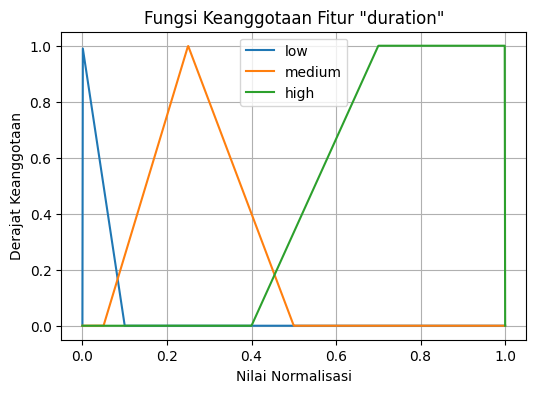

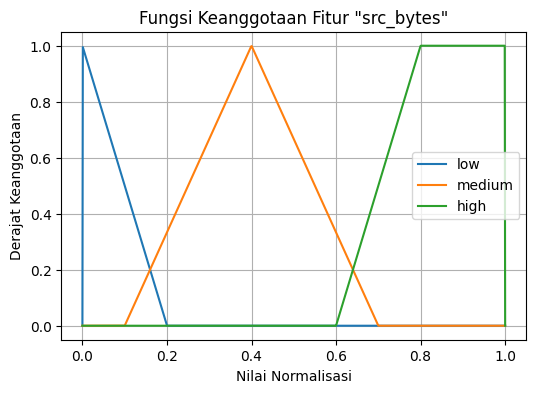

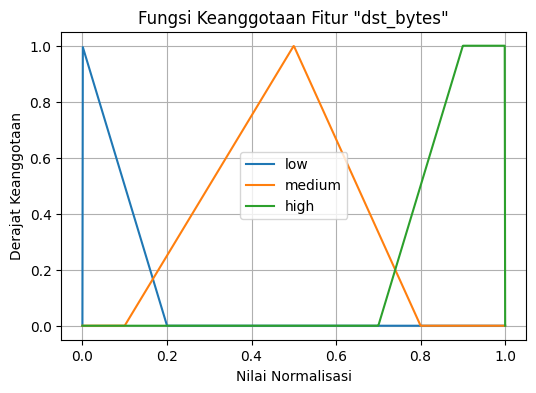

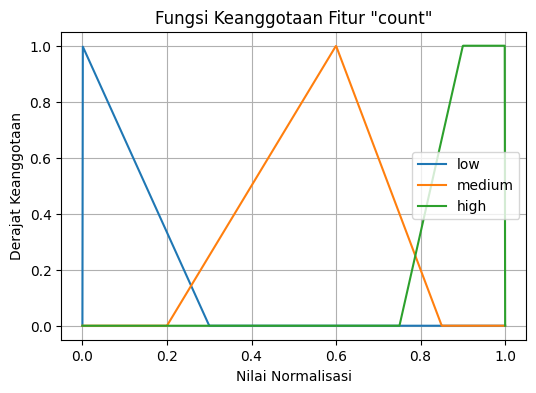

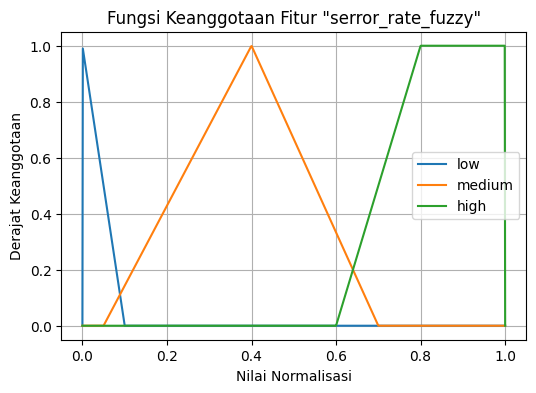

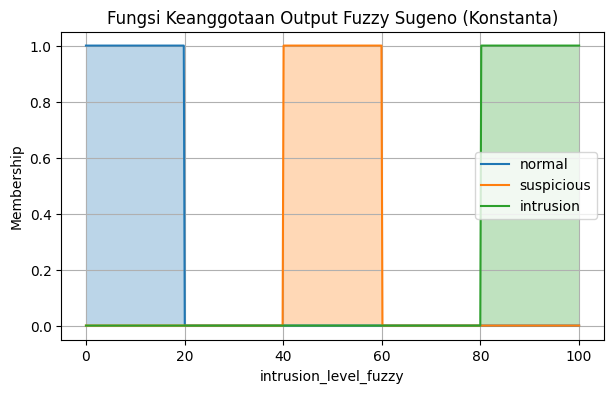

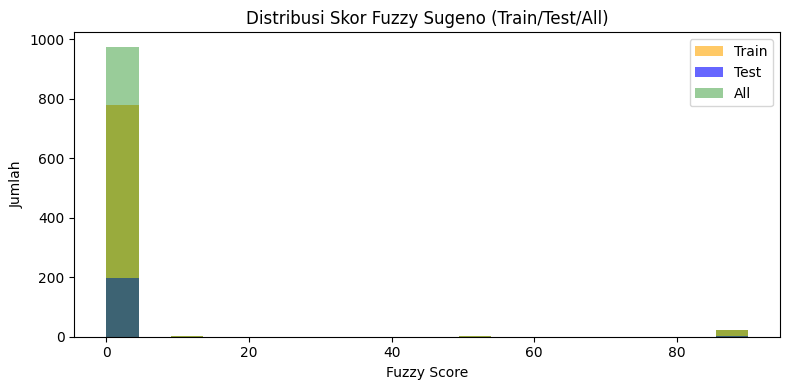

Kolom 'label' tidak ditemukan di dataset, evaluasi metrik tidak dapat dilakukan.


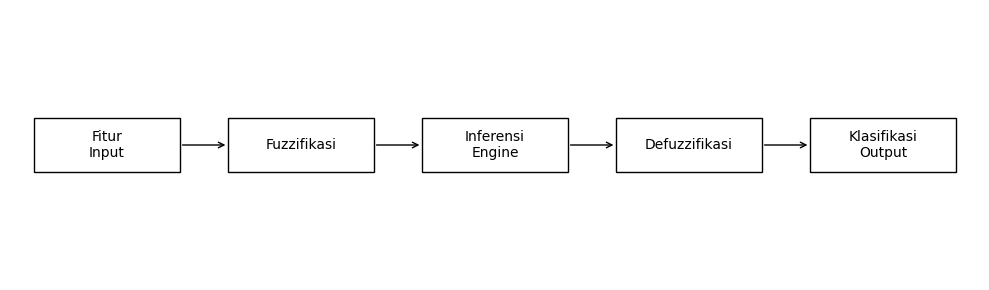


Wilcoxon test untuk src_bytes: statistic = 508.0000, p-value = 0.2151


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Load data dan preprocessing
_df_fuzzy = pd.read_csv('D:/MATERI KULIAH/Semester 4/Dasar Kecerdasan Artifisial/Tubes/Test_data.csv/Test_data.csv')
_df_fuzzy.replace('?', np.nan, inplace=True)
_df_fuzzy.dropna(inplace=True)

# Pastikan kolom serror_rate_fuzzy ada
if 'serror_rate' not in _df_fuzzy.columns:
    if 'dst_host_serror_rate' in _df_fuzzy.columns:
        _df_fuzzy['serror_rate_fuzzy'] = _df_fuzzy['dst_host_serror_rate']
    else:
        _df_fuzzy['serror_rate_fuzzy'] = 0.0
else:
    _df_fuzzy['serror_rate_fuzzy'] = _df_fuzzy['serror_rate']

# Sampling data
_df_sample_fuzzy = _df_fuzzy.sample(n=1000, random_state=42).reset_index(drop=True)

# Normalisasi fitur
_features_fuzzy = ['duration', 'src_bytes', 'dst_bytes', 'count', 'serror_rate_fuzzy']
_scaler = MinMaxScaler()
_X_fuzzy_norm = pd.DataFrame(_scaler.fit_transform(_df_sample_fuzzy[_features_fuzzy]), columns=_features_fuzzy)

# Membership function params untuk Sugeno (trimf/trapmf)
mf_params = {
    'duration': {
        'low':    ([0, 0, 0.1], 'trimf'),
        'medium': ([0.05, 0.25, 0.5], 'trimf'),
        'high':   ([0.4, 0.7, 1, 1], 'trapmf'),
    },
    'src_bytes': {
        'low':    ([0, 0, 0.2], 'trimf'),
        'medium': ([0.1, 0.4, 0.7], 'trimf'),
        'high':   ([0.6, 0.8, 1, 1], 'trapmf'),
    },
    'dst_bytes': {
        'low':    ([0, 0, 0.2], 'trimf'),
        'medium': ([0.1, 0.5, 0.8], 'trimf'),
        'high':   ([0.7, 0.9, 1, 1], 'trapmf'),
    },
    'count': {
        'low':    ([0, 0, 0.3], 'trimf'),
        'medium': ([0.2, 0.6, 0.85], 'trimf'),
        'high':   ([0.75, 0.9, 1, 1], 'trapmf'),
    },
    'serror_rate_fuzzy': {
        'low':    ([0, 0, 0.1], 'trimf'),
        'medium': ([0.05, 0.4, 0.7], 'trimf'),
        'high':   ([0.6, 0.8, 1, 1], 'trapmf'),
    }
}

def plot_mf(feature_name, mf_dict):
    x = np.linspace(0, 1, 1000)
    plt.figure(figsize=(6,4))
    for label, (params, mf_type) in mf_dict.items():
        if mf_type == 'trimf':
            a,b,c = params
            y = np.piecewise(x,
                             [x <= a, (a < x) & (x <= b), (b < x) & (x < c), x >= c],
                             [0,
                              lambda x: (x - a)/(b - a) if (b - a) > 0 else 0,
                              lambda x: (c - x)/(c - b) if (c - b) > 0 else 0,
                              0])
        elif mf_type == 'trapmf':
            a,b,c,d = params
            y = np.piecewise(x,
                             [x <= a, (a < x) & (x <= b), (b < x) & (x <= c), (c < x) & (x < d), x >= d],
                             [0,
                              lambda x: (x - a)/(b - a) if (b - a) > 0 else 0,
                              1,
                              lambda x: (d - x)/(d - c) if (d - c) > 0 else 0,
                              0])
        else:
            y = np.zeros_like(x)
        plt.plot(x, y, label=label)
    plt.title(f'Fungsi Keanggotaan Fitur "{feature_name}"')
    plt.xlabel('Nilai Normalisasi')
    plt.ylabel('Derajat Keanggotaan')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot semua fitur
for feat in mf_params:
    plot_mf(feat, mf_params[feat])

# Output konstanta rule Sugeno
output_constants = {
    'normal': 10,
    'suspicious': 50,
    'intrusion': 90,
}

x = np.linspace(0, 100, 500)

# Membership fungsi output Sugeno sebagai fungsi "step" / trapezoid dengan nilai konstan
def sugeno_mf(x, center, width=20):
    # Fungsi membership trapezoid yang naik dan turun secara linear sekitar center
    left = center - width/2
    right = center + width/2
    y = np.piecewise(x,
                     [x < left, (x >= left) & (x <= right), x > right],
                     [0, 1, 0])
    return y

plt.figure(figsize=(7,4))
plt.plot(x, sugeno_mf(x, output_constants['normal']), label='normal')
plt.plot(x, sugeno_mf(x, output_constants['suspicious']), label='suspicious')
plt.plot(x, sugeno_mf(x, output_constants['intrusion']), label='intrusion')

plt.fill_between(x, 0, sugeno_mf(x, output_constants['normal']), alpha=0.3)
plt.fill_between(x, 0, sugeno_mf(x, output_constants['suspicious']), alpha=0.3)
plt.fill_between(x, 0, sugeno_mf(x, output_constants['intrusion']), alpha=0.3)

plt.title('Fungsi Keanggotaan Output Fuzzy Sugeno (Konstanta)')
plt.xlabel('intrusion_level_fuzzy')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

# Rules fuzzy Sugeno (antecedent -> consequent)
rules = [
    ({'duration':'low', 'src_bytes':'low', 'dst_bytes':'low', 'count':'low', 'serror_rate_fuzzy':'low'}, 'normal'),
    ({'duration':'high'}, 'intrusion'),
    ({'src_bytes':'high'}, 'intrusion'),
    ({'dst_bytes':'high'}, 'intrusion'),
    ({'count':'high', 'serror_rate_fuzzy':'high'}, 'intrusion'),
    ({'duration':'medium', 'src_bytes':'medium', 'dst_bytes':'medium', 'count':'medium', 'serror_rate_fuzzy':'medium'}, 'suspicious'),
    ({'serror_rate_fuzzy':'high'}, 'intrusion'),
    ({'duration':'high', 'count':'high'}, 'intrusion'),
    ({'src_bytes':'high', 'dst_bytes':'low'}, 'suspicious'),
    ({'dst_bytes':'high', 'src_bytes':'low'}, 'suspicious'),
    ({'count':'medium', 'serror_rate_fuzzy':'high'}, 'intrusion'),
    ({'duration':'low', 'count':'high'}, 'suspicious'),
]



# Fungsi hitung membership degree
def membership_degree(x, params, mf_type='trimf'):
    if mf_type == 'trimf':
        a,b,c = params
        if x <= a or x >= c:
            return 0
        elif a < x <= b:
            return (x - a) / (b - a) if b!=a else 0
        elif b < x < c:
            return (c - x) / (c - b) if c!=b else 0
        else:
            return 0
    elif mf_type == 'trapmf':
        a,b,c,d = params
        if x <= a or x >= d:
            return 0
        elif a < x <= b:
            return (x - a) / (b - a) if b!=a else 0
        elif b < x <= c:
            return 1
        elif c < x < d:
            return (d - x) / (d - c) if d!=c else 0
        else:
            return 0
    else:
        return 0

# Fungsi hitung firing strength rule
def rule_firing_strength(sample, conds):
    degrees = []
    for feat, lbl in conds.items():
        deg = membership_degree(sample[feat], mf_params[feat][lbl][0], mf_params[feat][lbl][1])
        degrees.append(deg)
    return min(degrees) if degrees else 0

# Fungsi inferensi Sugeno (weighted average)
def infer_sugeno(sample):
    strengths = []
    outputs = []
    for conds, out_label in rules:
        strength = rule_firing_strength(sample, conds)
        strengths.append(strength)
        outputs.append(output_constants[out_label])
    if sum(strengths) == 0:
        return 0
    return sum(s*o for s,o in zip(strengths, outputs)) / sum(strengths)

def plot_confusion_matrices(true_labels, preds, title_prefix='Sugeno'):
    from sklearn.metrics import confusion_matrix

    # Binary Confusion Matrix
    binary_true = [0 if l == 'Normal' else 1 for l in true_labels]
    binary_pred = [0 if p == 'Normal' else 1 for p in preds]
    cm_bin = confusion_matrix(binary_true, binary_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_bin, annot=True, fmt='d', cmap='PuBu', xticklabels=['Normal', 'Intrusion'], yticklabels=['Normal', 'Intrusion'])
    plt.title(f'Confusion Matrix - {title_prefix} Biner')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Multi-class Confusion Matrix
    labels_order = ['Normal', 'Probe', 'R2L', 'DoS', 'U2R']
    cm_multi = confusion_matrix(true_labels, preds, labels=labels_order)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Greens', xticklabels=labels_order, yticklabels=labels_order)
    plt.title(f'Confusion Matrix - {title_prefix} Multi-Kelas')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


# Inferensi dan klasifikasi
scores = []
preds = []
for _, row in _X_fuzzy_norm.iterrows():
    score = infer_sugeno(row)
    scores.append(score)
    if score <= 30:
        pred = 'Normal'
    elif score <= 60:
        pred = 'Probe'
    elif score <= 80:
        pred = 'R2L'
    else:
        pred = 'DoS' if row['dst_bytes'] > 0.5 else 'U2R'
    preds.append(pred)

_df_sample_fuzzy['sugeno_score'] = scores
_df_sample_fuzzy['sugeno_prediction'] = preds

# Tampilkan hasil prediksi dan distribusi skor
plt.figure(figsize=(8,4))
plt.hist(_df_sample_fuzzy.loc[_idx_train_fuzzy, 'sugeno_score'], bins=20, alpha=0.6, label='Train', color='orange')
plt.hist(_df_sample_fuzzy.loc[_idx_test_fuzzy, 'sugeno_score'], bins=20, alpha=0.6, label='Test', color='blue')
plt.hist(_df_sample_fuzzy['sugeno_score'], bins=20, alpha=0.4, label='All', color='green')
plt.title("Distribusi Skor Fuzzy Sugeno (Train/Test/All)")
plt.xlabel("Fuzzy Score")
plt.ylabel("Jumlah")
plt.legend()
plt.tight_layout()
plt.show()

# Jika ada kolom label di dataset, lakukan evaluasi
if 'label' in _df_sample_fuzzy.columns:
    true_labels = _df_sample_fuzzy['label'].str.strip().str.lower().str.rstrip('.').map({
        'normal': 'Normal', 'dos': 'DoS', 'probe': 'Probe', 'r2l': 'R2L', 'u2r': 'U2R'
    }).fillna(_df_sample_fuzzy['label'])

    plot_confusion_matrices(true_labels, preds, title_prefix='Sugeno')

    print("=== Evaluasi Sugeno (Biner) ===")
    print(f"Akurasi  : {accuracy_score(binary_true, binary_pred):.4f}")
    print(f"Precision: {precision_score(binary_true, binary_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(binary_true, binary_pred, zero_division=0):.4f}")
    print(f"F1-Score : {f1_score(binary_true, binary_pred, zero_division=0):.4f}")

    print("\n=== Evaluasi Sugeno (Multi-Kelas) ===")
    print(classification_report(true_labels, preds, zero_division=0))

else:
    print("Kolom 'label' tidak ditemukan di dataset, evaluasi metrik tidak dapat dilakukan.")

fig, ax = plt.subplots(figsize=(10,3))
ax.set_axis_off()
blocks = [
    ("Fitur\nInput", 0.1),
    ("Fuzzifikasi", 0.3),
    ("Inferensi\nEngine", 0.5),
    ("Defuzzifikasi", 0.7),
    ("Klasifikasi\nOutput", 0.9),
]
width, height = 0.15, 0.2
for label, x in blocks:
    rect = Rectangle((x - width/2, 0.4), width, height, fill=False)
    ax.add_patch(rect)
    ax.text(x, 0.5, label, ha='center', va='center')
for i in range(len(blocks) - 1):
    x_start = blocks[i][1] + width/2
    x_end = blocks[i+1][1] - width/2
    ax.annotate("", xy=(x_end, 0.5), xytext=(x_start, 0.5), arrowprops=dict(arrowstyle='->'))
plt.tight_layout()
plt.show()

# Wilcoxon test dengan augmentasi noise ringan pada fitur src_bytes
_df_aug_fuzzy = _df_sample_fuzzy.copy()
_df_aug_fuzzy['src_bytes'] = _df_aug_fuzzy['src_bytes'].astype(float)
_indices_aug_fuzzy = np.random.choice(_df_aug_fuzzy.index, size=int(0.05 * len(_df_aug_fuzzy)), replace=False)
_df_aug_fuzzy.loc[_indices_aug_fuzzy, 'src_bytes'] += np.random.normal(loc=0, scale=10, size=len(_indices_aug_fuzzy))

_original_fuzzy = _df_sample_fuzzy.loc[_indices_aug_fuzzy, 'src_bytes']
_augmented_fuzzy = _df_aug_fuzzy.loc[_indices_aug_fuzzy, 'src_bytes']

if len(_original_fuzzy) == len(_augmented_fuzzy):
    stat_wilcoxon, p_wilcoxon = wilcoxon(_original_fuzzy, _augmented_fuzzy)
    print(f"\nWilcoxon test untuk src_bytes: statistic = {stat_wilcoxon:.4f}, p-value = {p_wilcoxon:.4f}")
else:
    print("\nTidak cukup data sepadan untuk Wilcoxon test.")




Mengapa grafik membership outputnya berbeda dengan grafik output Fuzzy Mamdani?
Fuzzy Mamdani punya output fuzzy yang berupa fungsi keanggotaan berbentuk kurva (trapezoid/triangle), sehingga grafiknya halus dan berbentuk overlapping fuzzy sets.

Fuzzy Sugeno outputnya berupa nilai konstan (rule consequents output numerik), sehingga grafik fungsi keanggotaannya biasanya digambarkan sebagai nilai konstan diskrit, bukan fungsi fuzzy yang halus sehingga membership output Sugeno berbentuk step functions (konstan), jadi tampilannya seperti tiga blok kotak yang berdampingan.

PERBANDINGAN KNN vs Fuzzy

KNN time: 0.44s, mean score: 0.0078
Fuzzy time: 2.17s, mean score: 0.0898
Fuzzy Sugeno time: 2.21s, mean score: 0.0898
Statistik deskriptif KNN:
  Mean   : 0.0078
  Std    : 0.0765
  Min    : 0.0000
  Median : 0.0000
  Max    : 1.0000

Statistik deskriptif Fuzzy Mamdani:
  Mean   : 0.0898
  Std    : 0.1233
  Min    : 0.0000
  Median : 0.1000
  Max    : 0.8833

Statistik deskriptif Fuzzy Sugeno:
  Mean   : 0.0898
  Std    : 0.1233
  Min    : 0.0000
  Median : 0.1000
  Max    : 0.8833

== Binary Classification (5-Fold CV Mean) ==
               Accuracy  Precision  Recall        F1
KNN               0.995   0.533333     0.5  0.493333
Fuzzy Mamdani     0.972   0.033333     0.1  0.050000
Fuzzy Sugeno      0.972   0.033333     0.1  0.050000

== Multi-Class Classification (5-Fold CV Mean) ==
               Accuracy  Precision    Recall        F1
KNN               0.995   0.764664  0.749495  0.745408
Fuzzy Mamdani     0.971   0.314028  0.310357  0.312180
Fuzzy Sugeno      0.971   0.314028  0.

C:\Users\Hp\AppData\Local\Temp\ipykernel_27232\2455918579.py:436: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([knn_scores, fuzzy_scores, fuzzy_sugeno_scores],


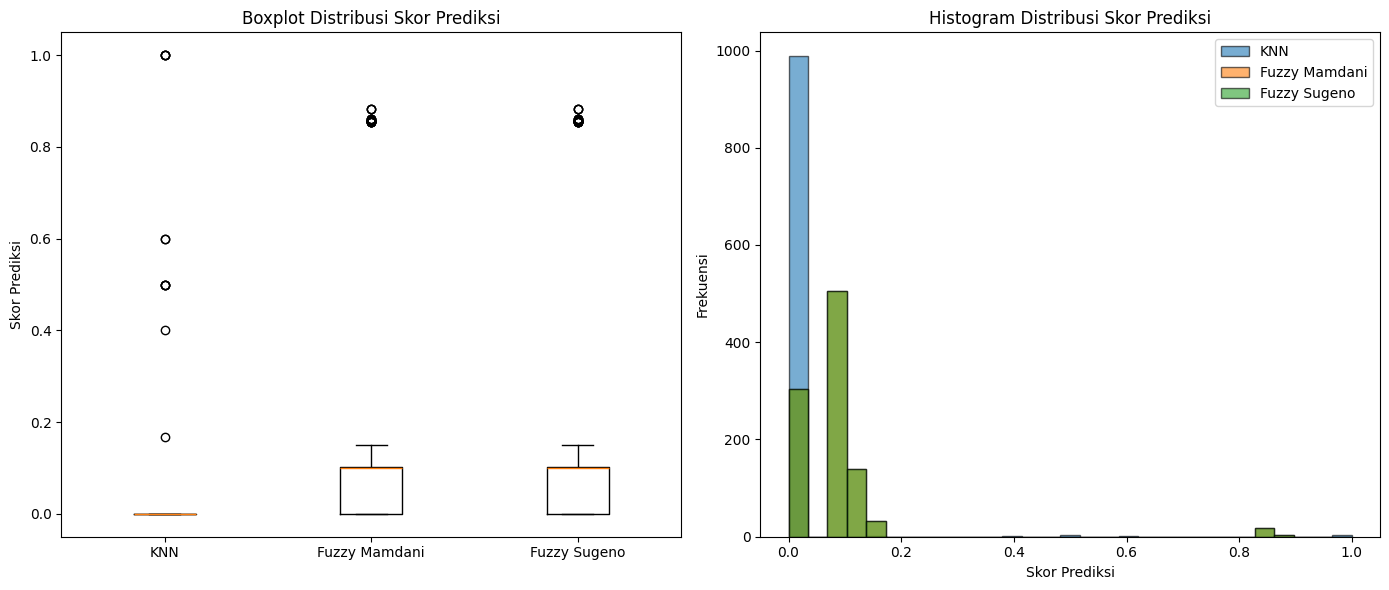

In [19]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import time
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support
)


# -----------------------------------------------------------------------------
# 1) Load & clean original data
# -----------------------------------------------------------------------------
df_orig = pd.read_csv('D:\MATERI KULIAH\Semester 4\Dasar Kecerdasan Artifisial\Tubes\Test_data.csv\Test_data.csv')
df_orig.replace('?', np.nan, inplace=True)
df_orig.dropna(inplace=True)

# Add serror_rate_fuzzy for fuzzy pipeline
if 'serror_rate' in df_orig.columns:
    df_orig['serror_rate_fuzzy'] = df_orig['serror_rate']
elif 'dst_host_serror_rate' in df_orig.columns:
    df_orig['serror_rate_fuzzy'] = df_orig['dst_host_serror_rate']
else:
    df_orig['serror_rate_fuzzy'] = 0.0

# Sample 1000 rows for fair comparison
df_orig = df_orig.sample(1000, random_state=42).reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2) Compute ground-truth labels using fuzzy features
# -----------------------------------------------------------------------------
fz_feats = ['duration','src_bytes','dst_bytes','count','serror_rate_fuzzy']
df_orig[fz_feats] = MinMaxScaler().fit_transform(df_orig[fz_feats])

# Score = mean of the 5 features * 100
df_orig['score'] = df_orig[fz_feats].mean(axis=1) * 100

def classify(score, dst):
    if score <= 30:
        return 'Normal'
    if score <= 60:
        return 'Probe'
    if score <= 80:
        return 'R2L'
    return 'DoS' if dst > 0.5 else 'U2R'

df_orig['attack_type']  = [classify(s, d) for s, d in zip(df_orig['score'], df_orig['dst_bytes'])]
df_orig['binary_label'] = df_orig['attack_type'].map(lambda x: 0 if x=='Normal' else 1)

# -----------------------------------------------------------------------------
# 3) Pipeline A: KNN with Stratified 5-Fold CV
# -----------------------------------------------------------------------------
# Prepare df_knn so we don't lose serror_rate_fuzzy
knn_feats = [
    'duration','protocol_type','service','flag',
    'src_bytes','dst_bytes','count','srv_count'
]
df_knn = df_orig[knn_feats + ['binary_label','attack_type']].copy()

# Encode categoricals
for c in ['protocol_type','service','flag']:
    df_knn[c] = LabelEncoder().fit_transform(df_knn[c])

# Normalize numeric for KNN
knn_num = ['duration','src_bytes','dst_bytes','count','srv_count']
df_knn[knn_num] = MinMaxScaler().fit_transform(df_knn[knn_num])

X_knn   = df_knn[knn_feats]
y_knn_b = df_knn['binary_label']
y_knn_m = df_knn['attack_type']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_bin_metrics, knn_multi_metrics = [], []

knn_scores_all = []
for train_i, test_i in skf.split(X_knn, y_knn_b):
    Xtr, Xte   = X_knn.iloc[train_i], X_knn.iloc[test_i]
    ytr_b, yte_b = y_knn_b.iloc[train_i], y_knn_b.iloc[test_i]
    ytr_m, yte_m = y_knn_m.iloc[train_i], y_knn_m.iloc[test_i]

    # Find best k in 1..10 for this fold
    best_k, best_acc = 1, 0
    for k in range(1, 11):
        model = KNeighborsClassifier(n_neighbors=k).fit(Xtr, ytr_b)
        acc = accuracy_score(yte_b, model.predict(Xte))
        if acc > best_acc:
            best_acc, best_k = acc, k

    # Evaluate binary
    knn_b = KNeighborsClassifier(n_neighbors=best_k).fit(Xtr, ytr_b)
    pred_b = knn_b.predict(Xte)
    probs_b = knn_b.predict_proba(Xte)[:,1] 
    knn_scores_all.extend(probs_b)  
    knn_bin_metrics.append([
        accuracy_score(yte_b, pred_b),
        precision_score(yte_b, pred_b, zero_division=0),
        recall_score(yte_b, pred_b, zero_division=0),
        f1_score(yte_b, pred_b, zero_division=0)
    ])

    # Evaluate multi-class
    knn_m = KNeighborsClassifier(n_neighbors=best_k).fit(Xtr, ytr_m)
    pred_m = knn_m.predict(Xte)
    prf = precision_recall_fscore_support(yte_m, pred_m, average='macro', zero_division=0)
    knn_multi_metrics.append([
        accuracy_score(yte_m, pred_m),
        prf[0], prf[1], prf[2]
    ])

knn_bin_mean   = np.array(knn_bin_metrics).mean(axis=0)
knn_multi_mean = np.array(knn_multi_metrics).mean(axis=0)

# -----------------------------------------------------------------------------
# 4) Pipeline B: Fuzzy Mamdani with Stratified 5-Fold CV
# -----------------------------------------------------------------------------
df_fz = df_orig.copy()  # still has serror_rate_fuzzy, score, labels

# Define fuzzy input variables
bounds = {
    'duration':          ([0,0,0.1],   [0.05,0.25,0.5], [0.4,0.7,1,1]),
    'src_bytes':         ([0,0,0.2],   [0.1,0.4,0.7],   [0.6,0.8,1,1]),
    'dst_bytes':         ([0,0,0.2],   [0.1,0.5,0.8],   [0.7,0.9,1,1]),
    'count':             ([0,0,0.3],   [0.2,0.6,0.85],  [0.75,0.9,1,1]),
    'serror_rate_fuzzy': ([0,0,0.1],   [0.05,0.4,0.7],  [0.6,0.8,1,1]),
}
vars_in = {}
for feat, (low_mf, med_mf, high_mf) in bounds.items():
    var = ctrl.Antecedent(np.linspace(0,1,101), feat)
    var['low']    = fuzz.trimf(var.universe,    low_mf)
    var['medium'] = fuzz.trimf(var.universe,    med_mf)
    var['high']   = fuzz.trapmf(var.universe,   high_mf)
    vars_in[feat] = var

# Define fuzzy output variable (must match lookup key)
out = ctrl.Consequent(np.arange(0,101,1), 'intrusion')
out['normal']     = fuzz.trimf(out.universe, [0,0,30])
out['suspicious'] = fuzz.trimf(out.universe, [20,50,80])
out['intrusion']  = fuzz.trapmf(out.universe, [70,85,100,100])

# Fuzzy rules
rules = [
    ctrl.Rule(vars_in['duration']['low']    &
              vars_in['src_bytes']['low']   &
              vars_in['dst_bytes']['low']   &
              vars_in['count']['low']       &
              vars_in['serror_rate_fuzzy']['low'],
              out['normal']),
    ctrl.Rule(vars_in['duration']['high']   |
              vars_in['src_bytes']['high']  |
              vars_in['dst_bytes']['high'],
              out['intrusion']),
    ctrl.Rule(vars_in['count']['high']      &
              vars_in['serror_rate_fuzzy']['high'],
              out['intrusion']),
    ctrl.Rule(vars_in['duration']['medium'] &
              vars_in['src_bytes']['medium'] &
              vars_in['dst_bytes']['medium'] &
              vars_in['count']['medium']     &
              vars_in['serror_rate_fuzzy']['medium'],
              out['suspicious']),
]
fuzzy_sys = ctrl.ControlSystem(rules)

# -----------------------------------------------------------------------------
# 4) Pipeline C: Fuzzy Sugeno with Stratified 5-Fold CV
# -----------------------------------------------------------------------------
vars_in_sugeno = {}
for feat, (low_mf, med_mf, high_mf) in bounds.items():
    var = ctrl.Antecedent(np.linspace(0,1,101), feat)
    var['low']    = fuzz.trimf(var.universe, low_mf)
    var['medium'] = fuzz.trimf(var.universe, med_mf)
    var['high']   = fuzz.trapmf(var.universe, high_mf)
    vars_in_sugeno[feat] = var

# Output variable Sugeno - gunakan output konstanta
out_sugeno = ctrl.Consequent(np.linspace(0, 100, 101), 'intrusion')
out_sugeno['normal']     = fuzz.trimf(out_sugeno.universe, [0, 0, 30])
out_sugeno['suspicious'] = fuzz.trimf(out_sugeno.universe, [20, 50, 80])
out_sugeno['intrusion']  = fuzz.trapmf(out_sugeno.universe, [70, 85, 100, 100])

# Aturan fuzzy Sugeno (samakan dengan rules di kode Sugeno)
rules_sugeno = [
    ctrl.Rule(vars_in_sugeno['duration']['low']    &
              vars_in_sugeno['src_bytes']['low']   &
              vars_in_sugeno['dst_bytes']['low']   &
              vars_in_sugeno['count']['low']       &
              vars_in_sugeno['serror_rate_fuzzy']['low'],
              out_sugeno['normal']),
    ctrl.Rule(vars_in_sugeno['duration']['high']   |
              vars_in_sugeno['src_bytes']['high']  |
              vars_in_sugeno['dst_bytes']['high'],
              out_sugeno['intrusion']),
    ctrl.Rule(vars_in_sugeno['count']['high']      &
              vars_in_sugeno['serror_rate_fuzzy']['high'],
              out_sugeno['intrusion']),
    ctrl.Rule(vars_in_sugeno['duration']['medium'] &
              vars_in_sugeno['src_bytes']['medium'] &
              vars_in_sugeno['dst_bytes']['medium'] &
              vars_in_sugeno['count']['medium']     &
              vars_in_sugeno['serror_rate_fuzzy']['medium'],
              out_sugeno['suspicious']),
]

# Buat sistem fuzzy Sugeno
fuzzy_sugeno_sys = ctrl.ControlSystem(rules_sugeno)

fz_bin_metrics, fz_multi_metrics = [], []
fuzzy_scores_all = []
for train_i, test_i in skf.split(df_fz, df_fz['binary_label']):
    sub = df_fz.iloc[test_i]
    yb  = sub['binary_label']
    ym  = sub['attack_type']

    bin_preds, multi_preds = [], []
    for _, row in sub.iterrows():
        sim = ctrl.ControlSystemSimulation(fuzzy_sys)
        try:
            for feat in bounds:
                val = row[feat]
                if pd.isna(val):
                    print(f"Warning: NaN detected in {feat} at index {row.name}")
                sim.input[feat] = val
            sim.compute()
            
            
            if 'intrusion' not in sim.output:
                raise KeyError("Output 'intrusion' tidak ditemukan")
            score = sim.output['intrusion']

            fuzzy_scores_all.append(score / 100)

            bin_preds.append(0 if score <= 30 else 1)
            if score <= 30:
                multi_preds.append('Normal')
            elif score <= 60:
                multi_preds.append('Probe')
            elif score <= 80:
                multi_preds.append('R2L')
            else:
                multi_preds.append('DoS' if row['dst_bytes'] > 0.5 else 'U2R')

        except Exception as e:
            bin_preds.append(0)
            multi_preds.append('Normal')


    # Evaluate this fold
    fz_bin_metrics.append([
        accuracy_score(yb, bin_preds),
        precision_score(yb, bin_preds, zero_division=0),
        recall_score(yb, bin_preds, zero_division=0),
        f1_score(yb, bin_preds, zero_division=0)
    ])
    prf = precision_recall_fscore_support(ym, multi_preds, average='macro', zero_division=0)
    fz_multi_metrics.append([
        accuracy_score(ym, multi_preds),
        prf[0], prf[1], prf[2]
    ])

fz_bin_mean   = np.array(fz_bin_metrics).mean(axis=0)
fz_multi_mean = np.array(fz_multi_metrics).mean(axis=0)

def evaluate_fuzzy_sugeno_cv(df, fuzzy_sugeno_sys, bounds):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    bin_metrics = []
    multi_metrics = []

    for train_i, test_i in skf.split(df, df['binary_label']):
        sub = df.iloc[test_i]
        yb = sub['binary_label']
        ym = sub['attack_type']

        bin_preds = []
        multi_preds = []
        for _, row in sub.iterrows():
            sim = ctrl.ControlSystemSimulation(fuzzy_sugeno_sys)
            try:
                for feat in bounds:
                    sim.input[feat] = row[feat]
                sim.compute()
                score = sim.output['intrusion']

                bin_preds.append(0 if score <= 30 else 1)
                if score <= 30:
                    multi_preds.append('Normal')
                elif score <= 60:
                    multi_preds.append('Probe')
                elif score <= 80:
                    multi_preds.append('R2L')
                else:
                    multi_preds.append('DoS' if row['dst_bytes'] > 0.5 else 'U2R')
            except Exception:
                bin_preds.append(0)
                multi_preds.append('Normal')

        bin_metrics.append([
            accuracy_score(yb, bin_preds),
            precision_score(yb, bin_preds, zero_division=0),
            recall_score(yb, bin_preds, zero_division=0),
            f1_score(yb, bin_preds, zero_division=0)
        ])
        prf = precision_recall_fscore_support(ym, multi_preds, average='macro', zero_division=0)
        multi_metrics.append([
            accuracy_score(ym, multi_preds),
            prf[0], prf[1], prf[2]
        ])

    bin_mean = np.array(bin_metrics).mean(axis=0)
    multi_mean = np.array(multi_metrics).mean(axis=0)
    return bin_mean, multi_mean


fz_sugeno_bin_mean, fz_sugeno_multi_mean = evaluate_fuzzy_sugeno_cv(df_fz, fuzzy_sugeno_sys, bounds)


def run_knn_cv(X, y):
    from time import time
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores_all = []
    start = time()
    for train_i, test_i in skf.split(X, y):
        Xtr, Xte = X.iloc[train_i], X.iloc[test_i]
        ytr, yte = y.iloc[train_i], y.iloc[test_i]

        best_k, best_acc = 1, 0
        for k in range(1, 11):
            model = KNeighborsClassifier(n_neighbors=k).fit(Xtr, ytr)
            acc = accuracy_score(yte, model.predict(Xte))
            if acc > best_acc:
                best_acc, best_k = acc, k

        model = KNeighborsClassifier(n_neighbors=best_k).fit(Xtr, ytr)
        probs = model.predict_proba(Xte)[:,1]
        scores_all.extend(probs)
    elapsed = time() - start
    return np.array(scores_all), elapsed

def run_fuzzy_cv(df, fuzzy_sys, bounds):
    from time import time
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores_all = []
    start = time()
    for train_i, test_i in skf.split(df, df['binary_label']):
        sub = df.iloc[test_i]
        for _, row in sub.iterrows():
            sim = ctrl.ControlSystemSimulation(fuzzy_sys)
            try:
                for feat in bounds:
                    sim.input[feat] = row[feat]
                sim.compute()
                score = sim.output['intrusion']
                scores_all.append(score / 100)
            except:
                scores_all.append(0)
    elapsed = time() - start
    return np.array(scores_all), elapsed

def run_fuzzy_sugeno_cv(df, fuzzy_sugeno_sys, bounds):
    from time import time
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores_all = []
    start = time()
    for train_i, test_i in skf.split(df, df['binary_label']):
        sub = df.iloc[test_i]
        for _, row in sub.iterrows():
            sim = ctrl.ControlSystemSimulation(fuzzy_sugeno_sys)
            try:
                for feat in bounds:
                    sim.input[feat] = row[feat]
                sim.compute()
                score = sim.output['intrusion']
                scores_all.append(score / 100)  # normalisasi 0-1
            except Exception:
                scores_all.append(0)
    elapsed = time() - start
    return np.array(scores_all), elapsed



knn_scores, knn_time = run_knn_cv(X_knn, y_knn_b)
fuzzy_scores, fuzzy_time = run_fuzzy_cv(df_fz, fuzzy_sys, bounds)
fuzzy_sugeno_scores, fuzzy_sugeno_time = run_fuzzy_sugeno_cv(df_fz, fuzzy_sugeno_sys, bounds)

print(f"KNN time: {knn_time:.2f}s, mean score: {knn_scores.mean():.4f}")
print(f"Fuzzy time: {fuzzy_time:.2f}s, mean score: {fuzzy_scores.mean():.4f}")
print(f"Fuzzy Sugeno time: {fuzzy_sugeno_time:.2f}s, mean score: {fuzzy_sugeno_scores.mean():.4f}")

# -----------------------------------------------------------------------------
# 5) Print descriptive statistic
# -----------------------------------------------------------------------------
def print_stats(name, scores):
    print(f"Statistik deskriptif {name}:")
    print(f"  Mean   : {np.mean(scores):.4f}")
    print(f"  Std    : {np.std(scores):.4f}")
    print(f"  Min    : {np.min(scores):.4f}")
    print(f"  Median : {np.median(scores):.4f}")
    print(f"  Max    : {np.max(scores):.4f}")
    print()

print_stats("KNN", knn_scores)
print_stats("Fuzzy Mamdani", fuzzy_scores)
print_stats("Fuzzy Sugeno", fuzzy_sugeno_scores)

# -----------------------------------------------------------------------------
# 6) Print comparison of mean 5-fold CV metrics
# -----------------------------------------------------------------------------
cols = ['Accuracy','Precision','Recall','F1']
df_binary = pd.DataFrame(
    [knn_bin_mean, fz_bin_mean,fz_sugeno_bin_mean],
    index=['KNN','Fuzzy Mamdani', 'Fuzzy Sugeno'],
    columns=cols
)
df_multi = pd.DataFrame(
    [knn_multi_mean, fz_multi_mean,fz_sugeno_multi_mean],
    index=['KNN','Fuzzy Mamdani', 'Fuzzy Sugeno'],
    columns=cols
)


print("== Binary Classification (5-Fold CV Mean) ==")
print(df_binary)
print("\n== Multi-Class Classification (5-Fold CV Mean) ==")
print(df_multi)

plt.figure(figsize=(14, 6))

# Boxplot distribusi skor
plt.subplot(1, 2, 1)
plt.boxplot([knn_scores, fuzzy_scores, fuzzy_sugeno_scores], 
            labels=['KNN', 'Fuzzy Mamdani', 'Fuzzy Sugeno'])
plt.title('Boxplot Distribusi Skor Prediksi')
plt.ylabel('Skor Prediksi')

# Histogram distribusi skor berdampingan
plt.subplot(1, 2, 2)
bins = np.linspace(0, 1, 30)
plt.hist(knn_scores, bins=bins, alpha=0.6, label='KNN', edgecolor='black')
plt.hist(fuzzy_scores, bins=bins, alpha=0.6, label='Fuzzy Mamdani', edgecolor='black')
plt.hist(fuzzy_sugeno_scores, bins=bins, alpha=0.6, label='Fuzzy Sugeno', edgecolor='black')
plt.title('Histogram Distribusi Skor Prediksi')
plt.xlabel('Skor Prediksi')
plt.ylabel('Frekuensi')
plt.legend()

plt.tight_layout()
plt.show()


